## Importing Libraries

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

plt.style.use('ggplot')

In [28]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")

In [29]:
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (7613, 5)
test shape: (3263, 4)


In [30]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [32]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

There is a lot of missing data in location column. Maybe we will try to avoid using it as location cannot be detected by reading the tweet.

## EDA

total disater tweets: 3271
total safe tweets: 4342


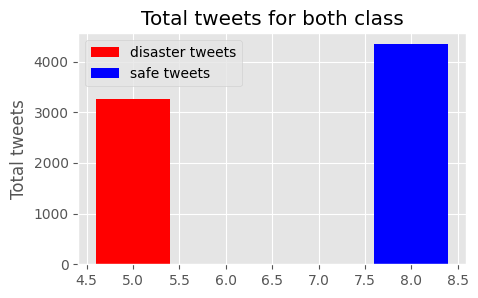

In [33]:
disaster_tweets=train[train['target']==1].shape[0]
safe_tweets=train[train['target']==0].shape[0]

print(f'total disater tweets: {disaster_tweets}')
print(f'total safe tweets: {safe_tweets}')

plt.figure(figsize=(5,3))
plt.bar(5,disaster_tweets,color='red',label='disaster tweets')
plt.bar(8,safe_tweets,color='blue',label='safe tweets')
plt.legend()
plt.title('Total tweets for both class')
plt.ylabel('Total tweets')
plt.show()

Both category are sufficiently balanced. Hence, there should me problem of biasness, poor generalization.

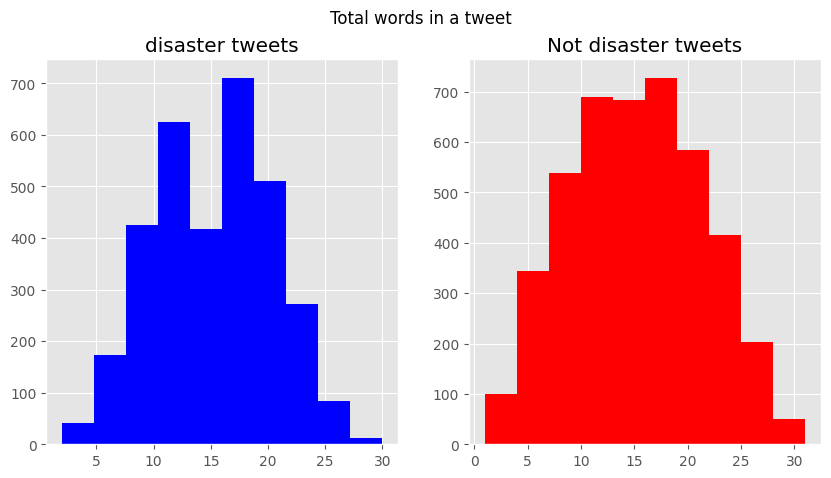

In [34]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Total words in a tweet')
plt.show()

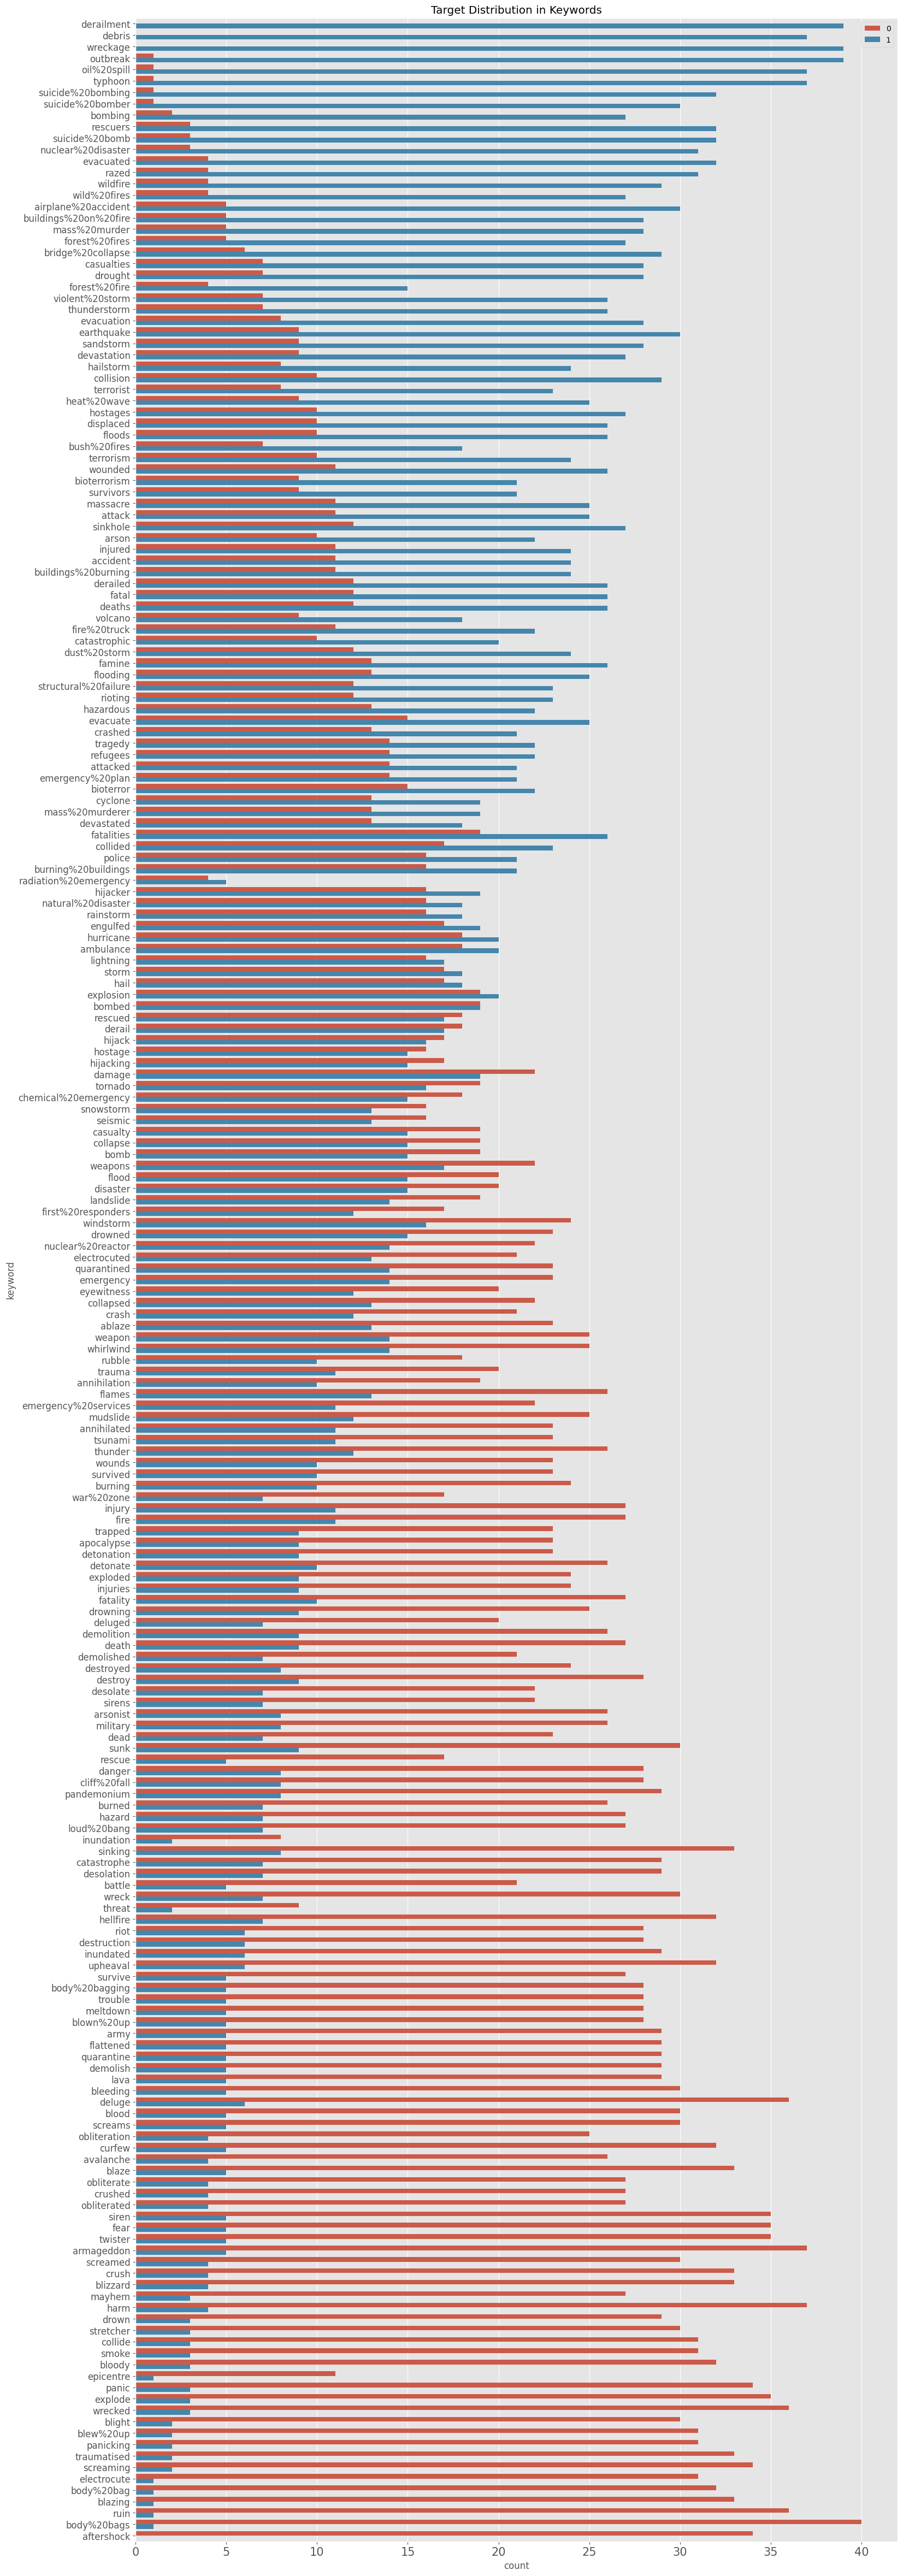

In [35]:
train['target_mean']=train.groupby('keyword')['target'].transform('mean')
fig=plt.figure(figsize=(18,60))
sns.countplot(y=train.sort_values(by='target_mean',ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean',ascending=False)['target'])
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

It can be seen that disasters like derailment, outbreak, oil spill, suicide bombing are most occuring and dominated while drowning, collision, lava are least occuring disaster.

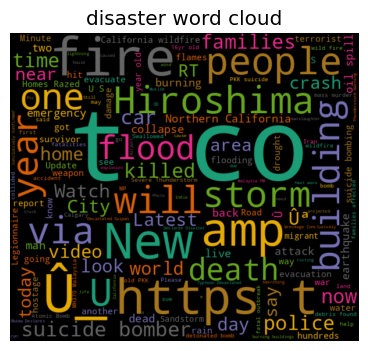

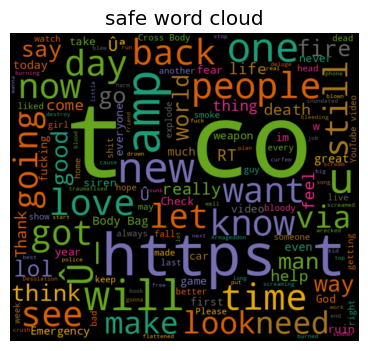

In [36]:
disaster_tweets=train.loc[train['target']==1]
safe_tweets=train.loc[train['target']==0]

d_text=disaster_tweets['text'].str.cat(sep=' ')
s_text=safe_tweets['text'].str.cat(sep=' ')

wc1=WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate(d_text)
wc2=WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate(s_text)

fig=plt.figure(figsize=(5,4))
plt.imshow(wc1,interpolation='bilinear')
plt.title('disaster word cloud')
plt.axis("off")
plt.show()

wc2=WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate(s_text)
fig=plt.figure(figsize=(5,4))
plt.imshow(wc2,interpolation='bilinear')
plt.title('safe word cloud')
plt.axis("off")
plt.show()

Most of the words that are occuring are spelling mistake, some special characters, or link of a website. hence, there is a heavy need of text pre-processing.

## Text Pre-Processing

In [37]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
#Lower casing : to reduce the dimensions of the data after vectorization.
train['text']=train['text'].str.lower()
train['keyword']=train['keyword'].str.lower()
test['text']=test['text'].str.lower()
test['keyword']=test['keyword'].str.lower()

In [39]:
#removing HTML tags:
def remove_tags(text):
  if isinstance(text,str):
    pattern=re.compile('<.*?>')
    return pattern.sub(r'',text)
  else:
    return text
train['text']=train['text'].apply(remove_tags)
test['text']=test['text'].apply(remove_tags)

In [40]:
# removing stopwords:
def remove_stopwords(text):
    new_text=[]
    for word in text.split():
        if word in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(word)
    x=new_text[:]
    new_text.clear()
    return ' '.join(x)
train['text']=train['text'].apply(remove_stopwords)
test['text']=test['text'].apply(remove_stopwords)

In [41]:
# Urls
def remove_url(text):
  text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
  return text
train['text']=train['text'].apply(remove_url)
test['text']=test['text'].apply(remove_url)

In [42]:
#remove punctuation
import string
exclude=string.punctuation
def remove_punc(text):
  if isinstance(text,str):
    return text.translate(str.maketrans('','',exclude))
  else:
    return text
train['text']=train['text'].apply(remove_punc)
test['text']=test['text'].apply(remove_punc)

In [43]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
train['text']=train['text'].apply(remove_emoji)
test['text']=test['text'].apply(remove_emoji)

In [44]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def to_full(df,column,abb_dict):
  df_copy=df.copy()
  df_copy[column]=df_copy[column].apply(lambda text: ' '.join([abbreviations.get(word, word) for word in text.split()]))
  return df_copy
train=to_full(train,'text',abbreviations)
test=to_full(test,'text',abbreviations)

In [45]:
def lemmatizing(text):
  lemmatizer= WordNetLemmatizer()
  words=nltk.word_tokenize(text)
  lemmatized_words=[lemmatizer.lemmatize(word) for word in words]
  return ' '.join(lemmatized_words)

train['text']=train['text'].apply(lemmatizing)
test['text']=test['text'].apply(lemmatizing)

In [46]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

## Vectorization and Model Applications

### Count Vectorizer method

In [47]:
cv=CountVectorizer()
X_text1=cv.fit_transform(train['text'])
X_num1=train[['unique_word_count','mean_word_length','char_count','word_count']]
X1=pd.concat([pd.DataFrame(X_text1.toarray()),X_num1],axis=1)
Y=train['target']

X1.columns = X1.columns.astype(str)

Logistic Regression

In [50]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, Y, test_size=0.2, random_state=42)

lr=LogisticRegression()
lr.fit(X_train1,y_train1)
y_pred = lr.predict(X_val1)

accuracy = accuracy_score(y_val1, y_pred)
precision = precision_score(y_val1, y_pred)
recall = recall_score(y_val1, y_pred)
f_lr_cv = f1_score(y_val1, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f_lr_cv:.4f}\n')

model=['LogisticRegression_CV']
score=[f_lr_cv]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7859
Precision: 0.7780
Recall: 0.6965
F1-score: 0.7350



Random Forest Clasiffier (RFC)

In [51]:
rfc1=RandomForestClassifier()
rfc1.fit(X_train1,y_train1)
y_pred=rfc1.predict(X_val1)
f_rfc_cv = f1_score(y_val1, y_pred)
print(f'F1-score: {f_rfc_cv:.4f}\n')

model.append('RandomForestClassifier')
score.append(f_rfc_cv)

F1-score: 0.7176



Randomized Search on RFC

In [52]:
param_distributions = {
    'n_estimators': [50, 100, 150, 200],                   # Number of trees in the forest
    'max_depth': [None, 5, 10, 15, 20],                    # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],                       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                         # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],             # Number of features to consider at each split
    'bootstrap': [True, False]                            # Whether to use bootstrap samples when building trees
}
random_search = RandomizedSearchCV(rfc1, param_distributions=param_distributions, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train1,y_train1)
best_params = random_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [53]:
rfc1=RandomForestClassifier(n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_features='sqrt', max_depth=None, bootstrap= False)
rfc1.fit(X_train1,y_train1)
y_pred=rfc1.predict(X_val1)
f1 = f1_score(y_val1, y_pred)
print(f'F1-score: {f1:.4f}\n')

F1-score: 0.7250



Multinomial Naive Bays

In [54]:
mnb1=MultinomialNB()
mnb1.fit(X_train1,y_train1)
y_pred=mnb1.predict(X_val1)
f_mnb1_cv = f1_score(y_val1, y_pred)
print(f'F1-score: {f_mnb1_cv:.4f}\n')

model.append('Multinomial NB')
score.append(f_mnb1_cv)

F1-score: 0.7518



Randomized Search on MultinomialNB

In [55]:
param_distributions = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],   # Additive (Laplace/Lidstone) smoothing parameter
    'fit_prior': [True, False]            # Whether to learn class prior probabilities or not
}
grid_search=GridSearchCV(mnb1,param_grid=param_distributions,cv=5)
grid_search.fit(X_train1,y_train1)
best_params=grid_search.best_params_
print(best_params)

{'alpha': 1.0, 'fit_prior': True}


In [56]:
mnb1=MultinomialNB(fit_prior=True,alpha=1.5)
mnb1.fit(X_train1,y_train1)
y_pred=mnb1.predict(X_val1)
f_mnb_cv = f1_score(y_val1, y_pred)
print(f'F1-score: {f_mnb_cv:.4f}\n')

F1-score: 0.7471



SVC

In [57]:
svc1=SVC()
svc1.fit(X_train1,y_train1)
y_pred=svc1.predict(X_val1)
f1 = f1_score(y_val1, y_pred)
print(f'F1-score: {f1:.4f}\n')

F1-score: 0.2782



SVC performed vey poorly and even randomized search CV is consuming 3hrs with no result.

Gradient Boosting Classifier

In [58]:
gbc1=GradientBoostingClassifier()
gbc1.fit(X_train1,y_train1)
predict=gbc1.predict(X_val1)
f_gbc_cv= f1_score(y_val1, y_pred)
print(f'F1-score: {f_gbc_cv:.4f}\n')

model.append('GradientBoostingClassifier')
score.append(f_gbc_cv)

F1-score: 0.2782



randomized Search on GBC

In [59]:
param_distributions = {
    'n_estimators': [50, 100, 150, 200],             # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.3],               # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5, 7],                          # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],                 # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5],                   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],       # Number of features to consider at each split
    'subsample': [0.5, 0.7, 0.9]                    # Fraction of samples used for fitting the trees
}
random_search=RandomizedSearchCV(gbc1,param_distributions=param_distributions,cv=5,n_iter=30,random_state=42)
random_search.fit(X_train1,y_train1)
best_params=random_search.best_params_
print(best_params)

{'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.3}


In [60]:
gbc1=GradientBoostingClassifier(subsample=0.9, n_estimators=200, min_samples_split=2,min_samples_leaf=5, max_features='sqrt', max_depth=7,learning_rate=0.3)
gbc1.fit(X_train1,y_train1)
predict=gbc1.predict(X_val1)
f1 = f1_score(y_val1, y_pred)
print(f'F1-score: {f1:.4f}\n')

F1-score: 0.2782



No improvement !!

## TfIdf Vectorizer

In [61]:
tfidf=TfidfVectorizer(ngram_range=(1,2),max_features=5000)
tfidf_vectorizer=tfidf.fit(train['text'])
X_text2=tfidf_vectorizer.transform(train['text'])
X_num2=train[['unique_word_count','mean_word_length','char_count','word_count']]
X2=pd.concat([pd.DataFrame(X_text2.toarray()),X_num2],axis=1)
Y=train['target']

X2.columns = X2.columns.astype(str)

ngram_range of (1,2) gave the best results till now.

In [62]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, Y, test_size=0.2, random_state=42)

lr=LogisticRegression()
lr.fit(X_train2,y_train2)
y_pred = lr.predict(X_val2)
f_lr_tfidf = f1_score(y_val2, y_pred)
print(f'F1-score: {f_lr_tfidf:.4f}\n')

# model.append('LogisticRegression_TfIdf')
# score.append(f_lr_tfidf)

F1-score: 0.7550



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
X_train2.shape

(6090, 5004)

Random Forest classifier()

In [64]:
rfc2=RandomForestClassifier()
rfc2.fit(X_train2,y_train2)
y_pred=rfc2.predict(X_val2)
f1 = f1_score(y_val2, y_pred)
print(f'F1-score: {f1:.4f}\n')

F1-score: 0.7076



Randomized Search on RFC

In [65]:
param_distributions = {
    'n_estimators': [50, 100, 150, 200],                   # Number of trees in the forest
    'max_depth': [None, 5, 10, 15, 20],                    # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],                       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                         # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],             # Number of features to consider at each split
    'bootstrap': [True, False]                            # Whether to use bootstrap samples when building trees
}
random_search = RandomizedSearchCV(rfc2, param_distributions=param_distributions, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train2,y_train2)
best_params = random_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


In [66]:
rfc2=RandomForestClassifier(n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features='log2', max_depth=None, bootstrap= True)
rfc2.fit(X_train2,y_train2)
y_pred=rfc2.predict(X_val2)
f_rfc_tfidf = f1_score(y_val2, y_pred)
print(f'F1-score: {f_rfc_tfidf:.4f}\n')

model.append('RandomForestClassifier_TfIdf')
score.append(f_rfc_tfidf)

F1-score: 0.7289



Multinomial Naive Bayes

In [67]:
mnb2=MultinomialNB()
mnb2.fit(X_train2,y_train2)
y_pred=mnb2.predict(X_val2)
f1 = f1_score(y_val2, y_pred)
print(f'F1-score: {f1:.4f}\n')

F1-score: 0.7294



Randomized Search on Multinomial NB

In [68]:
param_distributions = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],   # Additive (Laplace/Lidstone) smoothing parameter
    'fit_prior': [True, False]            # Whether to learn class prior probabilities or not
}
grid_search=GridSearchCV(mnb2,param_grid=param_distributions,cv=5)
grid_search.fit(X_train2,y_train2)
best_params=grid_search.best_params_
print(best_params)

{'alpha': 1.0, 'fit_prior': False}


In [ ]:
mnb2=MultinomialNB(fit_prior=False,alpha=0.5)
mnb2.fit(X_train2,y_train2)
y_pred=mnb2.predict(X_val2)
f_mnb_tfidf = f1_score(y_val2, y_pred)
print(f'F1-score: {f_mnb_tfidf:.4f}\n')

model.append('Multinomial NB_Tfidf')
score.append(f_mnb_tfidf)

Gradient Boosting Classifer (GBC)

In [69]:
gbc2=GradientBoostingClassifier()
gbc2.fit(X_train2,y_train2)
predict=gbc2.predict(X_val2)
f1 = f1_score(y_val2, y_pred)
print(f'F1-score: {f1:.4f}\n')

F1-score: 0.7294



Randomized Search on GBC

In [70]:
param_distributions = {
    'n_estimators': [50, 100, 150, 200],             # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.3],               # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5, 7],                          # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],                 # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5],                   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],       # Number of features to consider at each split
    'subsample': [0.5, 0.7, 0.9]                    # Fraction of samples used for fitting the trees
}
random_search=RandomizedSearchCV(gbc2,param_distributions=param_distributions,cv=5,n_iter=30,random_state=42)
random_search.fit(X_train2,y_train2)
best_params=random_search.best_params_
print(best_params)

{'subsample': 0.9, 'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.3}


In [71]:
gbc2=GradientBoostingClassifier(subsample=0.9, n_estimators=150, min_samples_split=5,min_samples_leaf=5, max_features='sqrt', max_depth=5,learning_rate=0.3)
gbc2.fit(X_train2,y_train2)
predict=gbc2.predict(X_val2)
f_gbc_tfidf = f1_score(y_val2, y_pred)
print(f'F1-score: {f_gbc_tfidf:.4f}\n')

model.append('GradientBoostingClassifier_TfIdf')
score.append(f_gbc_tfidf)

F1-score: 0.7294



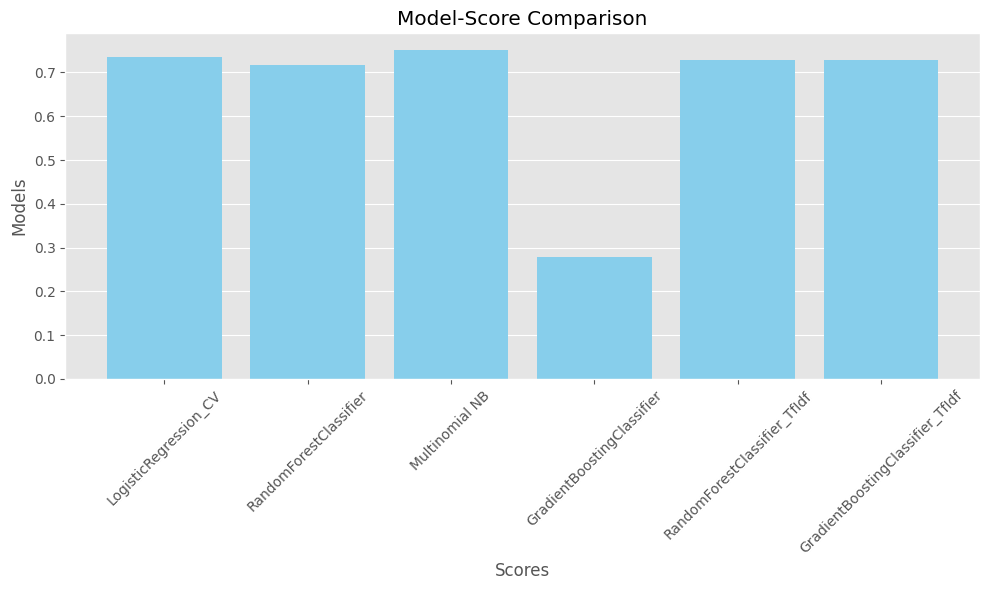

In [72]:
plt.figure(figsize=(10,6))
plt.bar(model,score,color='skyblue')

plt.xlabel('Scores')
plt.ylabel('Models')
plt.title('Model-Score Comparison')
plt.grid(axis='x')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From comparison all the models on Count Vectorizer and TfIdf Vectorizer we can infer that Logistic Regession performed well with TfIdf vectorizer with an F1-Score of 75.97%

## Model Application

In [73]:
user_input=input('Enter your tweet:  ')
user=pd.DataFrame({'text':[user_input]})

user['text']=user['text'].str.lower()
user['text']=user['text'].apply(remove_tags)
user['text']=user['text'].apply(remove_url)
user['text']=user['text'].apply(remove_stopwords)
user['text']=user['text'].apply(remove_punc)

user['word_count'] = user['text'].apply(lambda x: len(str(x).split()))
user['unique_word_count'] = user['text'].apply(lambda x: len(set(str(x).split())))
user['mean_word_length'] = user['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
user['char_count'] = user['text'].apply(lambda x: len(str(x)))


def vectorize_text(data,text, tfidf_vectorizer):
    data_trans = tfidf_vectorizer.transform(data[text])
    return data_trans

user_vec = vectorize_text(user, 'text', tfidf_vectorizer)
user_num=user[['unique_word_count','mean_word_length','char_count','word_count']]
user_transformed=pd.concat([pd.DataFrame(user_vec.toarray()),user_num],axis=1)
user_transformed.columns = user_transformed.columns.astype(str)
pred=lr.predict(user_transformed)

if pred==1:
  print('A Disaster tweet')
else:
  print('A safe tweet')

Enter your tweet:  today's dream was a nightmare
A safe tweet
